In [ ]:
#구글 드라이브 > 코랩 압축해제 코드

from google.colab import drive
import zipfile
from tqdm import tqdm  # 진행률 표시를 위한 라이브러리
import os

# 1. Google Drive 마운트
drive.mount('/content/drive')

# 2. 경로 설정
zip_path = '/content/drive/MyDrive/bdd100k-zero-dce+EDSR.zip'
extract_path = '/content/bdd100k-zero-dce+EDSR'  # 해제할 폴더

# 3. 압축 해제 (진행률 표시)
try:
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"파일이 존재하지 않습니다: {zip_path}")

    print(f"압축 해제 시작: {zip_path} -> {extract_path}")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 파일 목록 가져오기
        file_list = zip_ref.namelist()

        # tqdm을 사용하여 진행률 바 생성
        for file in tqdm(file_list, desc="Extracting", unit="file"):
            zip_ref.extract(file, extract_path)

    print("\n모든 압축 해제가 완료되었습니다.")

except Exception as e:
    print(f"\n오류 발생: {e}")

Mounted at /content/drive
압축 해제 시작: /content/drive/MyDrive/bdd100k-zero-dce+EDSR.zip -> /content/bdd100k-zero-dce+EDSR


Extracting: 100%|██████████| 63808/63808 [03:17<00:00, 322.75file/s] 


모든 압축 해제가 완료되었습니다.


In [ ]:
!pip install roboflow -q

from roboflow import Roboflow
rf = Roboflow(api_key="DaDo5dURQRX43RGzMUq8")
project = rf.workspace("test-wrkdf").project("bdd100k-finetune")
version = project.version(3)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 131.4 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bdd100k-finetune-3 in yolov11:: 100%|██████████| 63810/63810 [00:06<00:00, 9493.29it/s] 


In [ ]:
!rm -rf /content/bdd100k-finetune-3

In [ ]:
pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.4 MB/s eta 0:00:00


In [ ]:
import os
import yaml

# 새로운 클래스 정의 (OMOT 논문 방식)
# 0: Vehicle (차량), 1: Pedestrian (보행자)
mapping = {
    'car': 0, 'bus': 0, 'truck': 0, 'bike': 0, 'motor': 0,
    'person': 1, 'rider': 1
}

dataset_path = '/content/bdd100k-zero-dce'
label_dirs = ['train/labels', 'valid/labels', 'test/labels']

print("🔄 라벨 통합 작업 시작...")

for dtype in label_dirs:
    target_dir = os.path.join(dataset_path, dtype)
    if not os.path.exists(target_dir): continue

    for label_file in os.listdir(target_dir):
        if not label_file.endswith('.txt'): continue

        file_path = os.path.join(target_dir, label_file)
        new_lines = []

        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])


# 10: bike, 11: bus, 12: car, 13: motor, 14: person, 15: rider, 21: truck
                if class_id == 12: new_id = 0 # car
                elif class_id == 11: new_id = 0 # bus
                elif class_id == 21: new_id = 0 # truck
                elif class_id == 10: new_id = 0 # bike
                elif class_id == 13: new_id = 0 # motor
                elif class_id == 14: new_id = 1 # person
                elif class_id == 15: new_id = 1 # rider
                else: continue # 숫자 라벨 등 나머지는 제거

                new_lines.append(f"{new_id} {' '.join(parts[1:])}\n")

# 수정된 내용 덮어쓰기
        with open(file_path, 'w') as f:
            f.writelines(new_lines)

# data.yaml 수정
yaml_path = os.path.join(dataset_path, 'data.yaml')
new_yaml = {
    'train': '/content/bdd100k-zero-dce/train/images',
    'val': '/content/bdd100k-zero-dce/valid/images',
    'test': '/content/bdd100k-zero-dce/test/images',
    'nc': 2,
    'names': ['Vehicle', 'Pedestrian']
}
with open(yaml_path, 'w') as f:
    yaml.dump(new_yaml, f)

print("✅ 클래스 통합 완료! (Vehicle, Pedestrian)")



🔄 라벨 통합 작업 시작...


FileNotFoundError: [Errno 2] No such file or directory: '/content/bdd100k-zero-dce/data.yaml'

In [ ]:
# Super Resolution에 필요한 모델 다운로드 (EDSR_x2.pb)
# x2는 해상도를 가로세로 2배씩 늘린다는 의미입니다.
!wget -O EDSR_x2.pb https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x2.pb

# OpenCV contrib 패키지 확인 (보통 Colab에는 설치되어 있으나 확인차)
!pip install opencv-contrib-python -q

--2026-01-14 13:27:49--  https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x2.pb
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x2.pb [following]
--2026-01-14 13:27:49--  https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x2.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38490162 (37M) [application/octet-stream]
Saving to: ‘EDSR_x2.pb’

EDSR_x2.pb          100%[===================>]  36.71M   173MB/s    in 0.2s    

2026-01-14 13:27:50 (173 MB/s) - ‘EDSR_x2.pb’ saved [38490162/38490162]



In [ ]:
# 기존 opencv 패키지 충돌 방지를 위해 삭제
!pip uninstall opencv-python opencv-python-headless opencv-contrib-python -y

# Super Resolution 기능이 포함된 contrib 버전 설치
!pip install opencv-contrib-python

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 38.8 MB/s eta 0:00:00


In [ ]:
import cv2
from cv2 import dnn_superres

# 오류가 해결되었는지 확인 (객체가 생성되면 성공)
sr = dnn_superres.DnnSuperResImpl_create()
print("✅ Super Resolution 모듈 로드 성공!")

✅ Super Resolution 모듈 로드 성공!


In [ ]:
pip install super_image -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 41.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import glob
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import requests
import numpy as np

# ==========================================
# 0. ZeroDCE 모델 클래스 (재확인용)
# ==========================================
class ZeroDCE(nn.Module):
    def __init__(self):
        super(ZeroDCE, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        number_f = 32
        self.e_conv1 = nn.Conv2d(3, number_f, 3, 1, 1, bias=True)
        self.e_conv2 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True)
        self.e_conv3 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True)
        self.e_conv4 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True)
        self.e_conv5 = nn.Conv2d(number_f*2, number_f, 3, 1, 1, bias=True)
        self.e_conv6 = nn.Conv2d(number_f*2, number_f, 3, 1, 1, bias=True)
        self.e_conv7 = nn.Conv2d(number_f*2, 24, 3, 1, 1, bias=True)

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))
        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))

        r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)

        x = x + r1*(torch.pow(x,2)-x)
        x = x + r2*(torch.pow(x,2)-x)
        x = x + r3*(torch.pow(x,2)-x)
        enhance_image_1 = x + r4*(torch.pow(x,2)-x)
        x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)
        x = x + r6*(torch.pow(x,2)-x)
        x = x + r7*(torch.pow(x,2)-x)
        enhance_image = x + r8*(torch.pow(x,2)-x)
        r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
        return enhance_image_1, enhance_image, r

# ==========================================
# 1. 올바른 가중치 파일 다운로드 (HuggingFace Raw Link)
# ==========================================
weights_path = 'weights.pth'

# 1) 기존 잘못된 파일 삭제
if os.path.exists(weights_path):
    os.remove(weights_path)
    print("🗑️ 기존 파일을 삭제했습니다.")

# 2) 검증된 링크에서 다운로드 (HuggingFace의 IanNathaniel 레포지토리 - 검증됨)
# URL: https://huggingface.co/spaces/IanNathaniel/Zero-DCE/resolve/main/Epoch99.pth
url = 'https://huggingface.co/spaces/IanNathaniel/Zero-DCE/resolve/main/Epoch99.pth'

print("⬇️ 가중치 파일 다운로드 중... (약 320KB)")
try:
    r = requests.get(url, allow_redirects=True)
    with open(weights_path, 'wb') as f:
        f.write(r.content)

    file_size = os.path.getsize(weights_path)
    print(f"✅ 다운로드 완료! 파일 크기: {file_size} bytes")

    # 파일 크기 검증 (너무 작으면 HTML일 확률 높음)
    if file_size < 10000:
        raise ValueError("파일 크기가 너무 작습니다. 다운로드 링크가 잘못되었을 수 있습니다.")

except Exception as e:
    print(f"❌ 다운로드 실패: {e}")

# ==========================================
# 2. 모델 로드 (에러 해결)
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

try:
    DCE_net = ZeroDCE().to(device)

    # [핵심] weights_only=False 추가 및 map_location 설정
    state_dict = torch.load(weights_path, map_location=device, weights_only=False)

    # 키 불일치(module. 접두사) 해결
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    DCE_net.load_state_dict(new_state_dict)
    DCE_net.eval()
    print("🎉 모델 로드 성공! 이제 데이터셋 변환 코드를 실행하세요.")

except Exception as e:
    print(f"❌ 모델 로드 중 에러 발생:\n{e}")
    print("💡 팁: 'UnpicklingError'가 계속 뜨면, 다운로드 링크가 막힌 것일 수 있습니다.")

# ==========================================
# 3. 데이터셋 전체 변환 (Train / Val / Test)
# ==========================================
# 경로 설정
src_root = '/content/bdd100k-finetune-3'       # 원본 데이터 폴더
dst_root = '/content/bdd100k-zero-dce'     # 저장할 데이터 폴더

splits = ['train', 'valid', 'test']  # BDD 폴더명에 맞게 'val' or 'valid' 확인 필요

for split in splits:
    # 1) 원본 이미지 폴더 찾기 (val/valid 혼용 대응)
    src_img_dir = os.path.join(src_root, split, 'images')
    if not os.path.exists(src_img_dir) and split == 'valid': # valid가 없으면 val 시도
        src_img_dir = os.path.join(src_root, 'val', 'images')

    if not os.path.exists(src_img_dir):
        print(f"⚠️ {split} 폴더가 없어 건너뜁니다: {src_img_dir}")
        continue

    # 2) 저장할 폴더 생성 (폴더명 통일: val -> valid)
    save_split_name = 'valid' if split in ['val', 'valid'] else split
    dst_img_dir = os.path.join(dst_root, save_split_name, 'images')
    os.makedirs(dst_img_dir, exist_ok=True)

    # 3) 이미지 리스트 가져오기
    image_paths = glob.glob(os.path.join(src_img_dir, '*.jpg')) + glob.glob(os.path.join(src_img_dir, '*.png'))
    print(f"\n📸 Processing {split} set... ({len(image_paths)} images)")
    print(f"   Source: {src_img_dir}")
    print(f"   Target: {dst_img_dir}")

    # 4) 변환 루프
    for img_path in tqdm(image_paths):
        filename = os.path.basename(img_path)
        save_path = os.path.join(dst_img_dir, filename)

        # 이미 처리된 파일은 스킵 (시간 절약)
        if os.path.exists(save_path):
            continue

        try:
            # 이미지 로드 및 전처리
            data_lowlight = cv2.imread(img_path)
            if data_lowlight is None: continue

            # (H, W, C) -> (C, H, W) -> Tensor -> GPU
            data_lowlight = (data_lowlight.astype('float32') / 255.0)
            data_lowlight = torch.from_numpy(data_lowlight).float()
            data_lowlight = data_lowlight.permute(2,0,1).to(device).unsqueeze(0)

            # 추론 (밝기 개선)
            with torch.no_grad():
                _, enhanced_image, _ = DCE_net(data_lowlight)

            # 후처리 및 저장
            enhanced_image = enhanced_image.squeeze(0).permute(1,2,0).cpu().numpy()
            enhanced_image = np.clip(enhanced_image * 255.0, 0, 255.0).astype('uint8')

            cv2.imwrite(save_path, enhanced_image)

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("\n🎉 모든 데이터셋의 Zero-DCE 전처리가 완료되었습니다!")

🗑️ 기존 파일을 삭제했습니다.
⬇️ 가중치 파일 다운로드 중... (약 320KB)
✅ 다운로드 완료! 파일 크기: 320017 bytes
🚀 Device: cuda
🎉 모델 로드 성공! 이제 데이터셋 변환 코드를 실행하세요.

📸 Processing train set... (27445 images)
   Source: /content/bdd100k-finetune-3/train/images
   Target: /content/bdd100k-zero-dce/train/images


100%|██████████| 27445/27445 [06:04<00:00, 75.31it/s]



📸 Processing valid set... (4394 images)
   Source: /content/bdd100k-finetune-3/valid/images
   Target: /content/bdd100k-zero-dce/valid/images


100%|██████████| 4394/4394 [00:57<00:00, 76.20it/s]



📸 Processing test set... (60 images)
   Source: /content/bdd100k-finetune-3/test/images
   Target: /content/bdd100k-zero-dce/test/images


100%|██████████| 60/60 [00:00<00:00, 76.83it/s]


🎉 모든 데이터셋의 Zero-DCE 전처리가 완료되었습니다!


In [ ]:
import shutil
import os

# 1. 경로 설정
src_root = '/content/bdd100k-finetune-3'       # 원본 라벨이 있는 곳
dst_root = '/content/bdd100k-zero-dce'     # 복사해 넣을 곳 (이미지가 있는 곳)

# 처리할 폴더 목록 (train, val, test)
# 주의: 데이터셋에 따라 'val' 폴더 이름이 'valid'일 수도 있습니다. 확인 후 필요하면 수정하세요.
splits = ['train', 'valid', 'test']

for split in splits:
    # 원본 라벨 경로 (예: .../train/labels)
    src_labels_dir = os.path.join(src_root, split, 'labels')

    # 목적지 라벨 경로 (예: .../datasets_sr_enhanced/train/labels)
    dst_labels_dir = os.path.join(dst_root, split, 'labels')

    # 원본 라벨 폴더가 존재하는지 확인
    if os.path.exists(src_labels_dir):
        print(f"📂 '{split}' 라벨 복사 중: {src_labels_dir} -> {dst_labels_dir}")

        # 폴더 통째로 복사 (dirs_exist_ok=True: 이미 폴더가 있어도 덮어쓰거나 합침)
        shutil.copytree(src_labels_dir, dst_labels_dir, dirs_exist_ok=True)
    else:
        print(f"⚠️ 경고: '{split}' 라벨 폴더를 찾을 수 없습니다. ({src_labels_dir})")
        # 혹시 폴더명이 valid인 경우를 대비해 안내
        if split == 'val':
            print("   (참고: BDD100K 데이터셋에 따라 폴더명이 'val' 대신 'valid'일 수 있습니다.)")

print("\n✅ 모든 라벨 복사 작업이 완료되었습니다!")

📂 'train' 라벨 복사 중: /content/bdd100k-finetune-3/train/labels -> /content/bdd100k-zero-dce/train/labels
📂 'valid' 라벨 복사 중: /content/bdd100k-finetune-3/valid/labels -> /content/bdd100k-zero-dce/valid/labels
📂 'test' 라벨 복사 중: /content/bdd100k-finetune-3/test/labels -> /content/bdd100k-zero-dce/test/labels

✅ 모든 라벨 복사 작업이 완료되었습니다!


In [ ]:
import yaml
import os
import shutil

# 1. 경로 설정
base_dir = '/content/bdd100k-zero-dce'
yaml_path = os.path.join(base_dir, 'data.yaml')

# 💡 [중요] 폴더 이름 불일치 자동 해결 ('val' vs 'valid')
# 사용자님의 이미지 생성 코드는 'valid'를 썼는데, 라벨 복사 코드가 'val'로 되어있을 수 있어 이를 맞춰줍니다.
target_split = 'valid' # BDD100K는 보통 valid 사용
wrong_split = 'val'

# 라벨 폴더가 'val'로 되어있다면 'valid'로 이름 변경
wrong_label_path = os.path.join(base_dir, wrong_split, 'labels')
target_label_path = os.path.join(base_dir, target_split, 'labels')

if os.path.exists(wrong_label_path) and not os.path.exists(target_label_path):
    print(f"🔧 폴더 이름 수정 중: {wrong_split} -> {target_split}")
    os.rename(wrong_label_path, target_label_path)
    # 혹시 상위 폴더 자체가 val이라면 그것도 처리 (구조에 따라 다름)

# 2. data.yaml 내용 정의 (새로운 경로 적용)
data = {
    'path': base_dir,       # 데이터셋 루트 경로
    'train': 'train/images',
    'val': 'valid/images',  # 폴더명을 'valid'로 통일
    'test': 'test/images',
    'names': {
        0: 'Vehicle',
        1: 'Pedestrian'
    },
    'nc': 2
}

# 3. 파일 생성
with open(yaml_path, 'w') as f:
    yaml.dump(data, f, sort_keys=False)

print(f"✅ data.yaml 생성 완료! 위치: {yaml_path}")
print("내용 확인:")
print(yaml.dump(data, sort_keys=False))

✅ data.yaml 생성 완료! 위치: /content/bdd100k-zero-dce/data.yaml
내용 확인:
path: /content/bdd100k-zero-dce
train: train/images
val: valid/images
test: test/images
names:
  0: Vehicle
  1: Pedestrian
nc: 2



In [ ]:
# GPU 사용 SR

import os
import glob
import torch
from super_image import EdsrModel, ImageLoader
from PIL import Image
from tqdm import tqdm

# 1. GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Using Device: {device}") # 'cuda'가 출력되어야 GPU를 쓰는 것입니다.

# 2. 모델 로드 (EDSR, x2)
# 처음 실행 시 모델 가중치를 자동으로 다운로드합니다.
model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=2)
model.to(device)
model.eval()

# 3. 데이터셋 경로 설정
dataset_root = '/content/bdd100k-zero-dce'
sub_dirs = ['train/images', 'valid/images', 'test/images']

print("🔄 GPU Super Resolution 시작...")

for sub_dir in sub_dirs:
    target_dir = os.path.join(dataset_root, sub_dir)
    if not os.path.exists(target_dir):
        continue

    image_paths = glob.glob(os.path.join(target_dir, '*.*'))
    print(f"📂 Processing {sub_dir} : {len(image_paths)} images")

    for img_path in tqdm(image_paths):
        try:
            # 이미지 로드
            image = Image.open(img_path).convert('RGB')

            # GPU로 전송 및 추론
            inputs = ImageLoader.load_image(image).to(device)
            with torch.no_grad(): # 그래디언트 계산 꺼서 메모리 아끼기
                preds = model(inputs)

            # 결과 저장 (덮어쓰기)
            ImageLoader.save_image(preds, img_path)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

print("✅ GPU 기반 Super Resolution 변환 완료!")

🚀 Using Device: cuda



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

pytorch_model_2x.pt:   0%|          | 0.00/5.51M [00:00<?, ?B/s]

https://huggingface.co/eugenesiow/edsr-base/resolve/main/pytorch_model_2x.pt
🔄 GPU Super Resolution 시작...
📂 Processing train/images : 27445 images


100%|██████████| 27445/27445 [37:40<00:00, 12.14it/s]


📂 Processing valid/images : 4394 images


100%|██████████| 4394/4394 [06:02<00:00, 12.13it/s]


📂 Processing test/images : 60 images


100%|██████████| 60/60 [00:04<00:00, 12.06it/s]

✅ GPU 기반 Super Resolution 변환 완료!


In [ ]:
#코랩 폴더 압축 후 내 드라이브 다운로드
import shutil
from google.colab import drive

# 1. 구글 드라이브 연결
drive.mount('/content/drive')

# 2. 경로 설정
source_dir = '/content/bdd100k-zero-dce+EDSR'
zip_name = 'bdd100k-zero-dce+EDSR' # 압축 파일 이름 (확장자 제외)
dest_zip_path = f'/content/drive/MyDrive/{zip_name}.zip'

# 3. 압축 및 이동
print("폴더를 압축하는 중입니다...")
shutil.make_archive(f'/content/{zip_name}', 'zip', source_dir)

print("압축 파일을 구글 드라이브로 이동 중입니다...")
shutil.copy(f'/content/{zip_name}.zip', dest_zip_path)

print(f"완료! 내 드라이브에 '{zip_name}.zip' 파일로 저장되었습니다.")

Mounted at /content/drive
폴더를 압축하는 중입니다...
압축 파일을 구글 드라이브로 이동 중입니다...
완료! 내 드라이브에 'bdd100k-zero-dce+EDSR.zip' 파일로 저장되었습니다.


In [ ]:
import ultralytics
from ultralytics import YOLO
import wandb

wandb.init(project='bdd_yolo11SR', name='zero-dce-only')
# wandb.login()
# 1. 모델 로드
# rtdetr-l.pt (Large) 또는 rtdetr-x.pt (X-Large) 선택 가능
# 처음엔 coco 데이터로 사전학습된 가중치를 자동으로 다운로드합니다.
model = YOLO('yolo11s.pt')

# 2. 학습 시작
# data 인자에는 위에서 다운로드 받은 폴더 안의 'data.yaml' 경로를 넣으세요.
results = model.train(
    data='/content/bdd100k-zero-dce/data.yaml',
    epochs=20,
    imgsz=640,            # [수정] SR로 이미지가 커졌으므로 입력 사이즈도 키워야 효과가 있습니다.
    batch=32,              # [수정] 해상도가 커지면 메모리를 많이 먹으므로 배치를 줄여야 할 수 있습니다 (32 -> 16 or 8)
    project='bdd_yolov11s_zero-dce',
    name='run_zero-dce-only',      # 실험 이름 변경 (구분하기 쉽게)
    device=0,
    optimizer='AdamW',
    amp=False,
)

wandb.finish()

New https://pypi.org/project/ultralytics/8.4.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.1 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/bdd100k-zero-dce/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=run_zero-dce-


--- Model Testing ---
Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3445.9±849.8 MB/s, size: 322.5 KB)
val: Scanning /content/datasets_sr_enhanced/test/labels... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 1.4Kit/s 0.0s
val: New cache created: /content/datasets_sr_enhanced/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.1it/s 3.7s
                   all         60        649      0.749      0.654      0.707      0.366
               Vehicle         60        635      0.762      0.665      0.755      0.438
            Pedestrian          9         14      0.737      0.643      0.659      0.294
Speed: 14.4ms preprocess, 10.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs

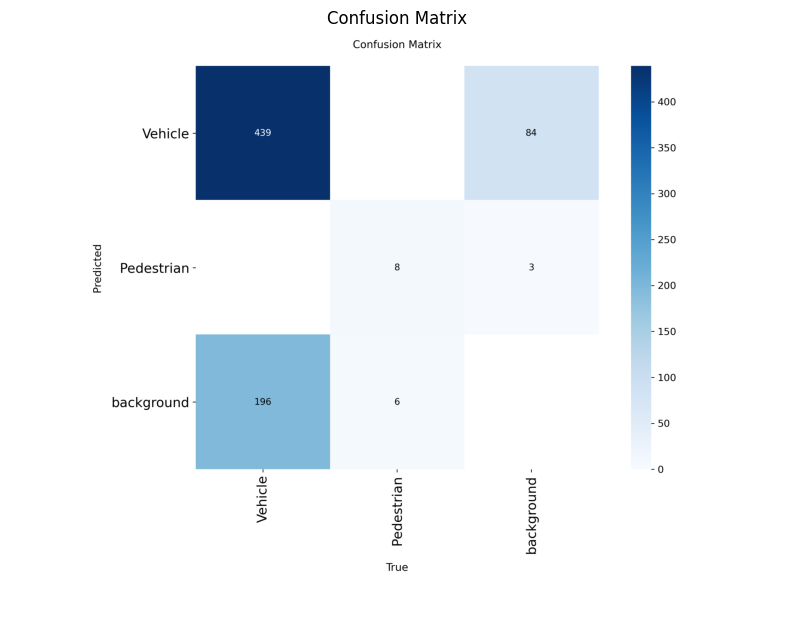

In [ ]:
print("\n--- Model Testing ---")
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import cv2

# 1. Load the best trained model
test_model = YOLO('/content/bdd_yolov11s_zero-dce/run_sr_x2/weights/best.pt')

# 2. Evaluate the model on the test set
# plots=True: 그래프(PR Curve, Confusion Matrix 등) 저장 활성화
test_results = test_model.val(data='/content/datasets_sr_enhanced/data.yaml', split='test', plots=True)

print("✅ Model testing complete.")

# --- 3. 수치 결과 출력 (Recall, Precision, mAP) ---
print("\n[Evaluation Metrics]")
print(f"Mean Precision (mp): {test_results.box.mp:.4f}")
print(f"Mean Recall (mr):    {test_results.box.mr:.4f}")
print(f"mAP@50:              {test_results.box.map50:.4f}")
print(f"mAP@50-95:           {test_results.box.map:.4f}")

# --- 4. 시각화 결과 출력 (저장된 이미지 불러오기) ---
# val()이 결과를 저장한 경로 가져오기
save_dir = test_results.save_dir

def show_result_image(filename, title):
    path = os.path.join(save_dir, filename)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ {filename} not found in {save_dir}")

print("\n--- Visualizations ---")
# 주요 그래프 시각화
show_result_image('PR_curve.png', 'Precision-Recall Curve') # PR 곡선
show_result_image('F1_curve.png', 'F1-Score Curve')         # F1 스코어 곡선
show_result_image('confusion_matrix.png', 'Confusion Matrix') # 혼동 행렬
# 필요하다면 P_curve.png (Precision), R_curve.png (Recall)도 추가 가능

In [ ]:
from google.colab import drive
import os

# 1. 구글 드라이브 마운트 (이 코드를 실행하면 인증 링크가 뜹니다)
drive.mount('/content/drive')

# 2. 모델을 저장할 폴더 경로 설정 (미리 폴더를 만들어 둡니다)
# 예: 내 드라이브의 'MyAI' 폴더 안에 'models' 폴더에 저장
save_path = '/content/drive/MyDrive/yolo11s/models'

# 폴더가 없으면 새로 만드는 코드 (에러 방지용)
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"폴더 생성 완료: {save_path}")
else:
    print(f"저장 경로 확인: {save_path}")

Mounted at /content/drive
폴더 생성 완료: /content/drive/MyDrive/yolo11s/models


In [ ]:
import shutil
import os

# 1. 원본 파일 경로 (User가 제공한 경로)
source_path = '/content/bdd_yolov11s_zero-dce/run_sr_x2/weights/best.pt'

# 2. 저장할 구글 드라이브 경로 (파일명 변경 가능)
# 예: /content/drive/MyDrive/MyAI/models 폴더에 'my_yolo_final.pt'로 저장
save_dir = '/content/drive/MyDrive/yolo11s/models'
save_name = 'yolov11s_2class_zero-dce-simple.pt' # 원하는 이름으로 바꾸세요
destination_path = os.path.join(save_dir, save_name)

# 3. 폴더가 없으면 생성
os.makedirs(save_dir, exist_ok=True)

# 4. 복사 실행
shutil.copy(source_path, destination_path)
print(f"모델 복사 완료: {destination_path}")

모델 복사 완료: /content/drive/MyDrive/yolo11s/models/yolov11s_2class_zero-dce-simple.pt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 39.1 MB/s eta 0:00:00
